In [ ]:
# Third Party
import transformers

# First Party
from granite_common import Granite33InputProcessor, UserMessage
from granite_common.granite3.granite33 import constants
from granite_common.granite3.types import (
    Granite3ChatCompletion,
)

# Introduction
Granite 3.x language models are lightweight, state-of-the-art, open foundation models that natively support multilinguality, coding, reasoning, and tool usage, including the potential to be run on constrained compute resources. All the models are publicly released under an Apache 2.0 license for both research and commercial use. The models' data curation and training procedure were designed for enterprise usage and customization, with a process that evaluates datasets for governance, risk and compliance (GRC) criteria, in addition to IBM's standard data clearance process and document quality checks. `granite_common` provides enhanced prompt creation and output parsing for IBM Granite models.
This notebook consists of a chat completion demo.
<br>
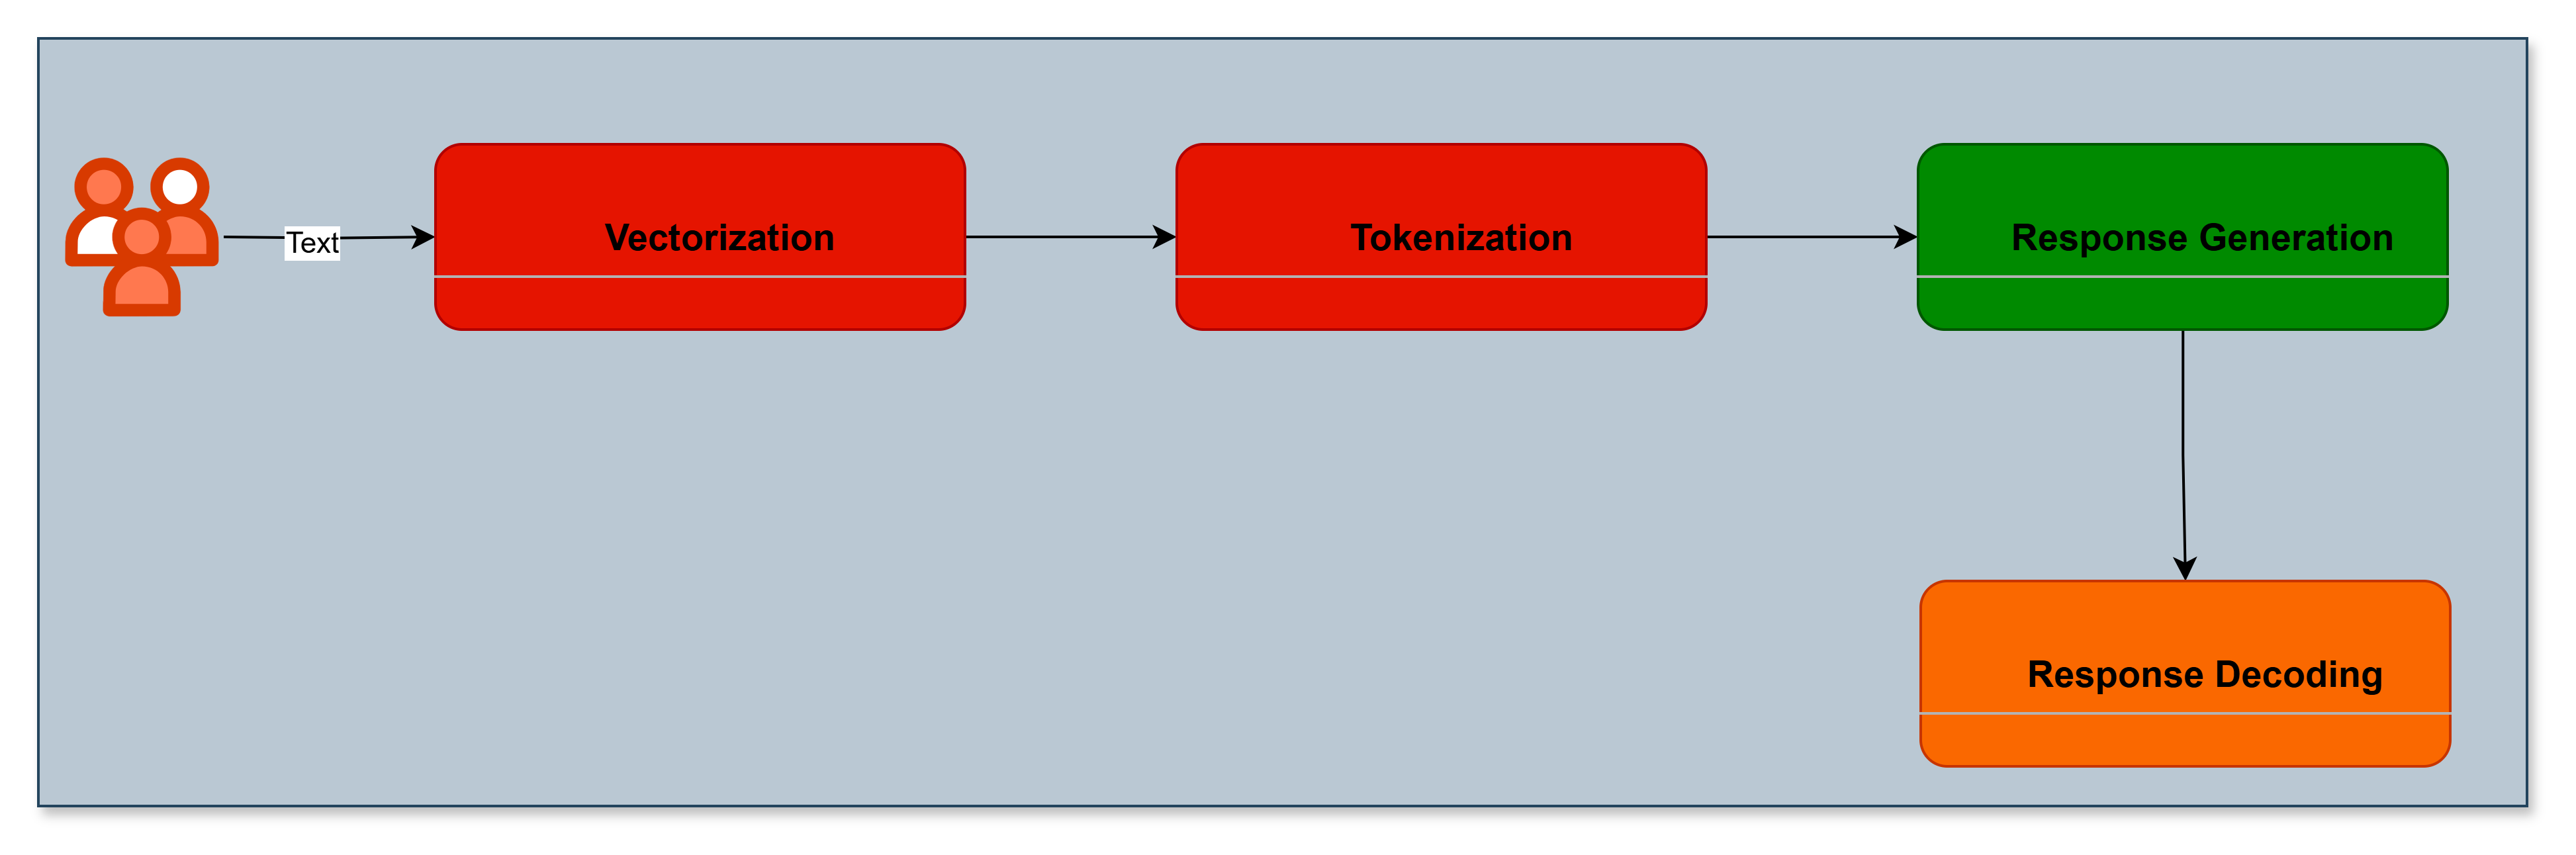

# Chat Completion

### Text Input

In [ ]:
# User chat input
user_msg = "What is 1 + 1? Answer with just a number please."

### Vectorization

In [ ]:
# Simple chat completion
chat_completion = Granite3ChatCompletion(
    # User input json
    messages=[UserMessage(content=user_msg)],
    extra_body={"chat_template_kwargs": {"thinking": True}},
)
prompt = Granite33InputProcessor().transform(chat_completion)
print(prompt)

### Model Initialization

In [ ]:
granite_model_path = constants.MODEL_HF_PATH_2B  # Hugging face pretrained model path.
granite_model = transformers.AutoModelForCausalLM.from_pretrained(
    granite_model_path,
    local_files_only=False,
    dtype="bfloat16",  # You'll get float32 if you don't set this.
)

### Tokenization

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    granite_model_path, local_files_only=False
)
model_input = tokenizer(prompt, return_tensors="pt").to(granite_model.device)

### Response Generation Configuration

In [ ]:
MAX_LENGTH = 1024  # Maximum character length of generated response
generation_config = transformers.GenerationConfig(
    max_length=MAX_LENGTH, num_beams=1, do_sample=False
)

### Response Generation

In [ ]:
model_output_tensor = granite_model.generate(
    **model_input, generation_config=generation_config
)

### Output Decoding

In [ ]:
model_output = tokenizer.decode(
    model_output_tensor[0, model_input["input_ids"].shape[1] :],
    skip_special_tokens=True,
)
print(model_output)

## Try Other Prompts

In [ ]:
# Other chat completion requests, serialized as JSON strings.
INPUT_JSON_STRS = {
    "simple": """
{
    "messages":
    [
        {"role": "user", "content": "Hello, how are you?"},
        {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
        {"role": "user", "content": "Say 'boo'!"}
    ]
}
""",
    "hallucinations": """
{
    "messages":
    [
        {"role": "user", "content": "Where is the fleeby floop?"}
    ],
    "extra_body": {
        "documents":
        [
            {"text": "The fleeby floop is in Maine."}
        ],
        "chat_template_kwargs": {"controls": {"hallucinations": true}}
    }
}
""",
    "custom_system_prompt": """
{
    "messages":
    [
        {"role": "system", "content": "Answer all questions like a three year old. \
Use as few words as possible. Be extremely concise."},
        {"role": "user", "content": "Hi, I would like some advice on the best tax \
strategy for managing dividend income."}
    ]
}
""",
    "tools": """
{
    "messages":
    [
        {"role": "user", "content": "Where is my money? I'm Joe User and I'm 27 years \
old."}
    ],
    "tools":[
        {
            "name": "get_current_weather",
            "description": "Get the current weather",
            "parameters": {
                "type": "object",
                "location": {
                    "type": "string",
                    "description": "The city and state, e.g. San Francisco, CA"
                }
            }
        },
        {
            "name": "find_money",
            "description": "Locate a person's money.",
            "parameters": {
                "type": "object",
                "name": {
                    "type": "string",
                    "description": "Full legal name of the person"
                },
                "age": {
                    "type": "integer",
                    "minimum": 0,
                    "description": "How old the person is"
                }
            }
        }
    ]

}
""",
    "documents": """
{
    "messages":
    [
        {"role": "user", "content": "What's another word for thesaurus?"}
    ],
    "extra_body": {
        "documents":
        [
            {"text": "It's a small world, but I wouldn't want to have to paint it."},
            {"text": "Whenever I think of the past, it brings back so many memories."}
        ]
    }
}
""",
}